In [2]:
%matplotlib inline

In [3]:
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
import pandas as pd

In [27]:
##### Parameters
G_i = 2 # 1 for Friendster, 2 for Les miserables network
if G_i == 1:
    tour_N = 25 #5
    tour_c = 0
    deg_def = [50]
    flag_fn = 1 # 1 for g(v) = d(v) > 25, 4 for avg clustering coeff
if G_i == 2:
    deg_def = [10,4]
    flag_fn = 4 # 1 for g(v) = d(v) > 10, 2 for g(v) = d(v) < 4, 3 for avg degree, 4 for avg clustering coeff
    
max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
MH_do = 1 # Flag for doing MH simulation
RDS_do = 1 # Flag for doing RDS simulation
RT_do = 1 # Flag for RT simulation
RR_do = 1 # Flag for RR simulation

In [28]:
def node_fn(node):
    if flag_fn == 1:
        temp = int(G.degree(node)>deg_def[0])
    elif flag_fn == 2:
        temp = int(G.degree(node)<deg_def[1])
    elif flag_fn == 3:
        temp = G.degree(node)
    elif flag_fn == 4:
        deg = G.degree(node)
        if deg < 2:
            temp = 0
        else:
            temp = 2*nx.triangles(G,node)/(deg*(deg-1))
    return temp

In [29]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        # print "MH_sample: ",ii
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [30]:
def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        # print "rds_sample: ",ii
        neighbors = list(nx.neighbors(G,sample))
        sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [31]:
def random_walk_tour_estimate(G,super_node,nbr_out_sup,F_org_sup_1,vol_sup_node,max_B,B_arr):

    R = []
    R_1 =[]
    R_2 = []
    summ = 0
    summ1 =0
    summ2 =0
    
    xi_arr = []
    xi_sum = 0

    size_super_node = len(super_node)
    tour_i = 1
    while xi_sum <= max_B:

        R_k1 = 0
        R_k2 = 0
        
        sample = random.choice(nbr_out_sup)
        xi = 1
        while sample not in super_node:
            deg_sample = G.degree(sample)
            R_k1 += node_fn(sample)/deg_sample
            R_k2 += 1/deg_sample
            xi += 1
            neighbors = list(nx.neighbors(G,sample))
            sample = random.choice(neighbors)

        R_k1 += F_org_sup_1/vol_sup_node
        R_k2 += size_super_node/vol_sup_node
        
        R_1.append(R_k1+summ1)
        R_2.append(R_k2+summ2)
        
        summ1 += R_k1
        summ2 += R_k2
        
        xi_sum += xi
        xi_arr.append(xi_sum)
        tour_i += 1

    R_1 = np.array(R_1)
    R_2 = np.array(R_2)
    R = R_1/R_2
    
    xi_arrr = np.array(xi_arr)
    ind = np.zeros(len(B_arr),dtype = int)
    for ii,it in enumerate(B_arr):
        ind[ii]=np.argmax(xi_arrr > it)-1 
        # Without -1, argmax chooses the xi_arrth element which crosses "it"
        # With -1, we go one step backwards
    return (R[ind])

In [32]:
def RR_sampling(G,B):
    M = np.sqrt(B)
    restart_ind = np.square(np.arange(1,M))
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            sample = np.random.choice(G.nodes)
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [33]:
if G_i == 1:
    G = nx.read_edgelist("friendster_community1_trimmed.edgelist",nodetype = int)
elif G_i == 2:
    G = nx.les_miserables_graph()
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)
G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()

In [34]:
if G_i == 1:
    ##########################CHECK
    if flag_fn == 1:
        F_org = 0.265712074303 #sum([1 for i in G.nodes() if G.degree(i) ])/G_no_nodes
    elif flag_fn == 4:
        F_org = 0.4491010966748313
    else:
        sys.exit("Invalid function")
        
elif G_i == 2:
    if (flag_fn == 1) or (flag_fn == 2):
        F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
    elif flag_fn == 3:
        F_org = 2*G_no_edges/G_no_nodes
    elif flag_fn == 4:
        F_org = nx.average_clustering(G)

In [35]:
if MH_do:
    MSE_MH_t = 0
    for ii in range(1,no_runs+1):
        MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
    MSE_MH = MSE_MH_t/(no_runs)
    MSE_MH = np.sqrt(MSE_MH)/F_org

In [36]:
if RDS_do:
    MSE_rds_t = 0
    for ii in range(1,no_runs+1):
        MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
    MSE_rds = MSE_rds_t/(no_runs)
    MSE_rds = np.sqrt(MSE_rds)/F_org

In [37]:
if RR_do:
    MSE_rr_t = 0
    for ii in range(1,no_runs+1):
        MSE_rr_t += (RR_sampling(G,max_B)-F_org)**2
    MSE_rr = MSE_rr_t/(no_runs)
    MSE_rr = np.sqrt(MSE_rr)/F_org

In [38]:
## Super-node calculations =================================================
'''
size_super_node = int(input("Size of super node (def = 1000): ") or "1000")
if size_super_node == 1:
    sup_node_1_sel = input("Select highest degree node (y/n), def = y): ") or "y"
    if sup_node_1_sel == 'y':
        super_node = [max(G.degree(), key=G.degree().get)]
        print("Selected the node with highest degree !!")
    else:
        super_node = random.sample(G.nodes(), size_super_node) #super-node formation from uniform samples
'''
size_super_node=25
if size_super_node != 1:
    super_node = random.sample(G.nodes(), size_super_node) #super-node formation from uniform samples
## =========================================================================

#Finding super_node's neighbours outside super node
nbr_out_sup=[]
sum_temp=0
F_org_sup_1=0
i=0
for node_s in super_node:
    #print("super node ", i)
    i+=1
    list_s_n=[node_s_n for node_s_n in nx.neighbors(G,node_s) if node_s_n not in super_node]
    nbr_out_sup=nbr_out_sup+list_s_n
    F_org_sup_1 += node_fn(node_s)

vol_sup_node = len(nbr_out_sup)
#print(vol_sup_node)
## ==========================================================================

In [39]:
if RT_do:
    B_arr = np.arange(100,max_B+1,100)
    MSE_rt_t = 0
    for ii in range(1,no_runs+1):
        MSE_rt_t += (random_walk_tour_estimate(G,super_node,nbr_out_sup,F_org_sup_1,vol_sup_node,max_B,B_arr)-F_org)**2
    MSE_rt = MSE_rt_t/(no_runs)
    MSE_rt = np.sqrt(MSE_rt)/F_org

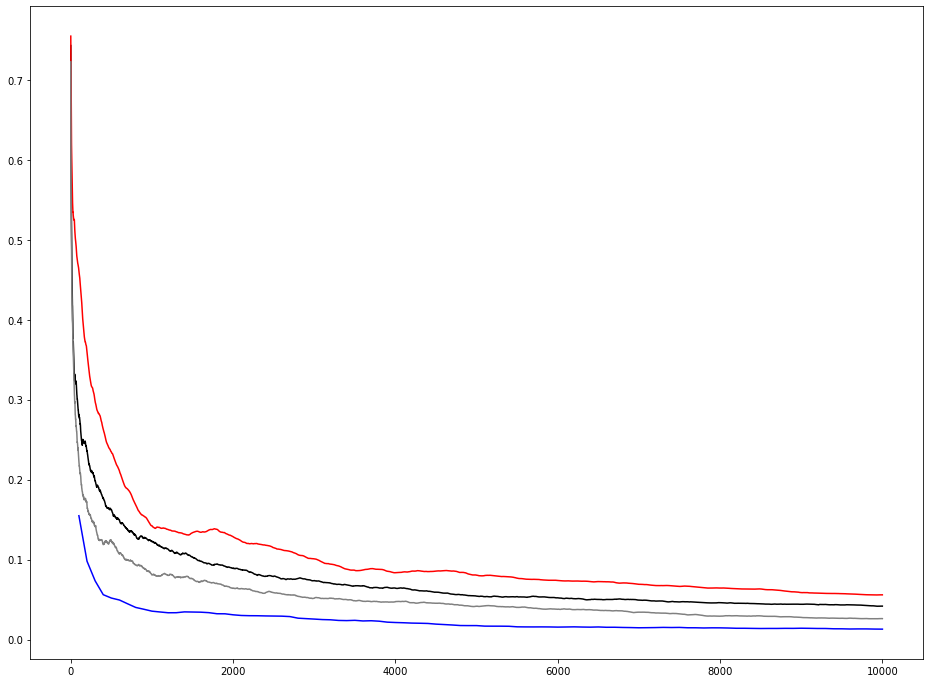

In [40]:
plt.figure(1,figsize=(16,12)) 
plt.plot(np.array(list(range(len(MSE_rr)))),MSE_rr,color='black')
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red')
plt.plot(B_arr,MSE_rt,color='blue')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='gray')